本章主要介绍深度强化学习领域的两个重要技术：策略梯度和深度Q网络(DQN)，包括马尔科夫决策过程(MDP)

我们将会使用这些技术来训练一个模型来平衡移动的车上的杆和玩吃豆人小游戏

In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os
import sys

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# To plot pretty figures and animations
%matplotlib nbagg
import matplotlib
import matplotlib.animation as animation
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
# PROJECT_ROOT_DIR = "."
# CHAPTER_ID = "rl"

# def save_fig(fig_id, tight_layout=True):
#     path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
#     print("Saving figure", fig_id)
#     if tight_layout:
#         plt.tight_layout()
#     plt.savefig(path, format='png', dpi=300)

In [69]:
import gym

In [70]:
env = gym.make('MsPacman-v0')

In [71]:
obs = env.reset()

In [72]:
obs.shape

(210, 160, 3)

In [73]:
img = env.render(mode="rgb_array")

<IPython.core.display.Javascript object>


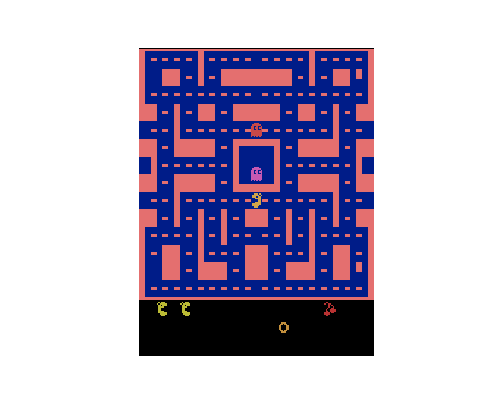

In [74]:
plt.figure(figsize=(5,4))
plt.imshow(img)
plt.axis("off")
# save_fig("MsPacman")
plt.show()

In [75]:
(img == obs).all()

True

In [76]:
def plot_environment(env, figsize=(5,4)):
    plt.close()  # or else nbagg sometimes plots in the previous cell
    plt.figure(figsize=figsize)
    img = env.render(mode="rgb_array")
    plt.imshow(img)
    plt.axis("off")
    plt.show()

In [77]:
env.action_space

Discrete(9)

In [78]:
env.reset()
for step in range(110):
    env.step(3) #left
for step in range(40):
    env.step(8) #lower-left

<IPython.core.display.Javascript object>


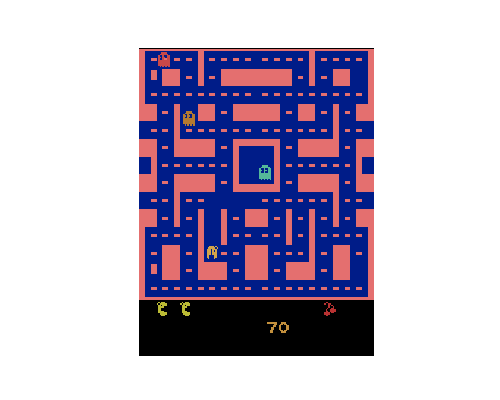

In [79]:
plot_environment(env)

In [81]:
obs, reward, done, info = env.step(0)

In [82]:
obs.shape

(210, 160, 3)

In [83]:
reward

0.0

In [84]:
done

False

In [85]:
info

{'ale.lives': 3}

In [86]:
frames = []

n_max_steps = 1000
n_change_steps = 10

obs = env.reset()
for step in range(n_max_steps):
    img = env.render(mode="rgb_array")
    frames.append(img)
    if step % n_change_steps == 0:
        action = env.action_space.sample() # play randomly
    obs, reward, done, info = env.step(action)
    if done:
        break

In [87]:
def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=40):
    plt.close()  # or else nbagg sometimes plots in the previous cell
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    return animation.FuncAnimation(fig, update_scene, fargs=(frames, patch), frames=len(frames), repeat=repeat, interval=interval)

<IPython.core.display.Javascript object>


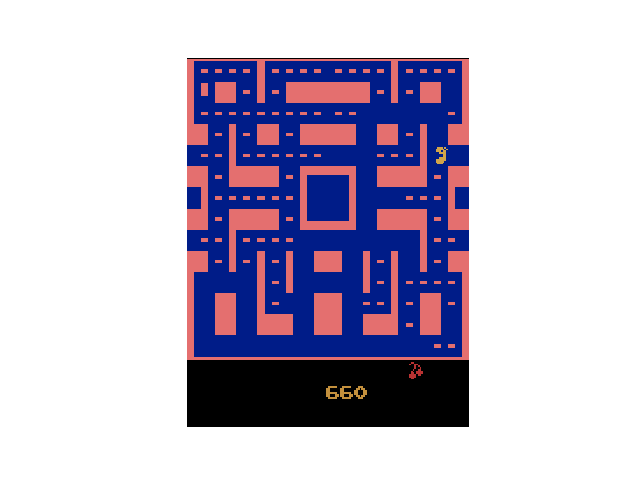

In [88]:
video = plot_animation(frames)
plt.show()

In [89]:
env.close()

In [90]:
env = gym.make("CartPole-v0")

In [91]:
obs = env.reset()

In [92]:
obs

array([-0.02388901,  0.00798195, -0.04190134, -0.03783025])

In [93]:
from PIL import Image, ImageDraw

try:
    from pyglet.gl import gl_info
    openai_cart_pole_rendering = True   # no problem, let's use OpenAI gym's rendering function
except Exception:
    openai_cart_pole_rendering = False  # probably no X server available, let's use our own rendering function

def render_cart_pole(env, obs):
    if openai_cart_pole_rendering:
        # use OpenAI gym's rendering function
        return env.render(mode="rgb_array")
    else:
        # rendering for the cart pole environment (in case OpenAI gym can't do it)
        img_w = 600
        img_h = 400
        cart_w = img_w // 12
        cart_h = img_h // 15
        pole_len = img_h // 3.5
        pole_w = img_w // 80 + 1
        x_width = 2
        max_ang = 0.2
        bg_col = (255, 255, 255)
        cart_col = 0x000000 # Blue Green Red
        pole_col = 0x669acc # Blue Green Red

        pos, vel, ang, ang_vel = obs
        img = Image.new('RGB', (img_w, img_h), bg_col)
        draw = ImageDraw.Draw(img)
        cart_x = pos * img_w // x_width + img_w // x_width
        cart_y = img_h * 95 // 100
        top_pole_x = cart_x + pole_len * np.sin(ang)
        top_pole_y = cart_y - cart_h // 2 - pole_len * np.cos(ang)
        draw.line((0, cart_y, img_w, cart_y), fill=0)
        draw.rectangle((cart_x - cart_w // 2, cart_y - cart_h // 2, cart_x + cart_w // 2, cart_y + cart_h // 2), fill=cart_col) # draw cart
        draw.line((cart_x, cart_y - cart_h // 2, top_pole_x, top_pole_y), fill=pole_col, width=pole_w) # draw pole
        return np.array(img)

def plot_cart_pole(env, obs):
    plt.close()  # or else nbagg sometimes plots in the previous cell
    img = render_cart_pole(env, obs)
    plt.imshow(img)
    plt.axis("off")
    plt.show()

<IPython.core.display.Javascript object>


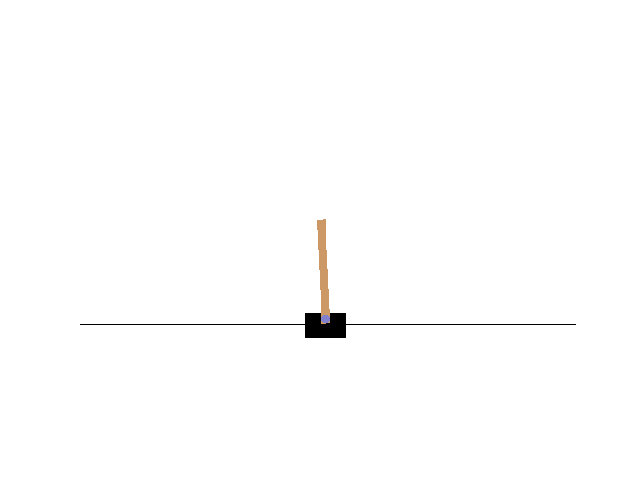

In [94]:
plot_cart_pole(env, obs)

In [95]:
env.action_space

Discrete(2)

In [96]:
obs = env.reset()
while True:
    obs, reward, done, info = env.step(0)
    if done:
        break

<IPython.core.display.Javascript object>


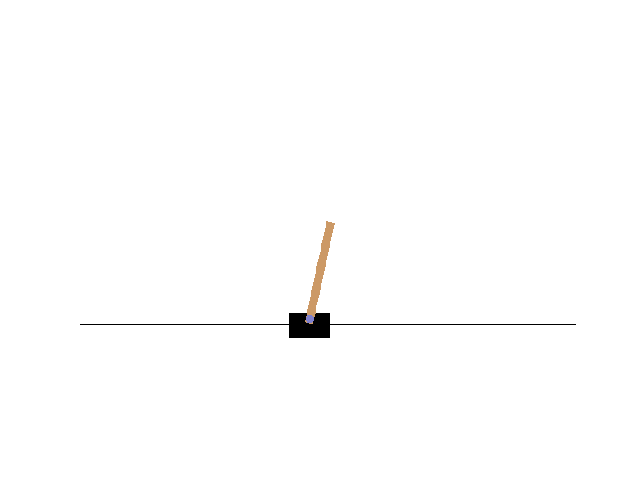

In [97]:
plot_cart_pole(env, obs)

In [98]:
img.shape

(210, 160, 3)

In [99]:
obs = env.reset()
while True:
    obs, reward, done, info = env.step(1)
    if done:
        break

<IPython.core.display.Javascript object>


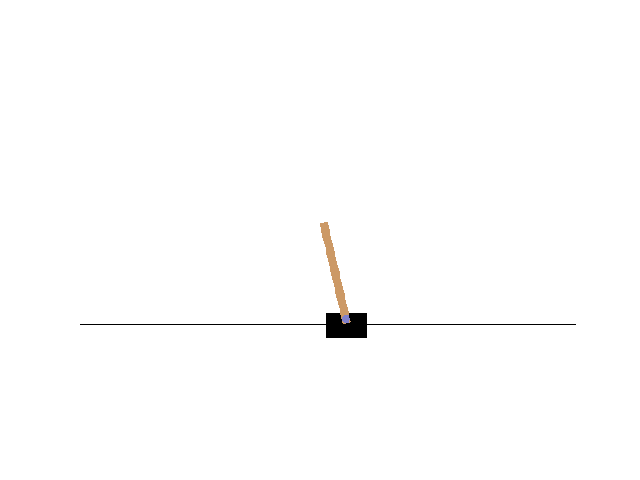

In [100]:
plot_cart_pole(env, obs)

硬编码一个简单的策略，如果杆向左，就加速向左，向右就加速向右

In [104]:
frames = []

n_max_steps = 10000
n_change_steps = 10

obs = env.reset()
for step in range(n_max_steps):
    img = render_cart_pole(env, obs)
    frames.append(img)

    # hard-coded policy
    position, velocity, angle, angular_velocity = obs
    if angle < 0:
        action = 0
    else:
        action = 1

    obs, reward, done, info = env.step(action)
    if done:
        break

<IPython.core.display.Javascript object>


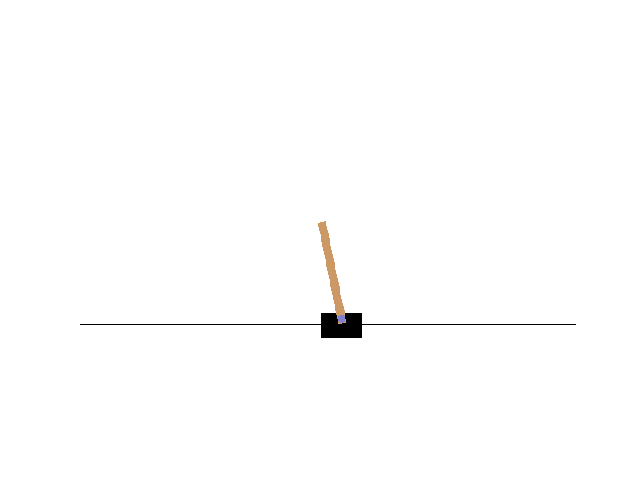

In [105]:
video = plot_animation(frames)
plt.show()

定义一个进行观察和输出的神经网络策略，但是缺少训练

In [106]:
import tensorflow as tf

# 1. Specify the network architecture
# obs 有四个值:当前位置、速度、杆的角度、角速度
n_inputs = 4  # == env.observation_space.shape[0]
n_hidden = 4  # it's a simple task, we don't need more than this
# 输出向左的概率
n_outputs = 1 # only outputs the probability of accelerating left
initializer = tf.variance_scaling_initializer()

# 2. Build the neural network
X = tf.placeholder(tf.float32, shape=[None, n_inputs])
hidden = tf.layers.dense(X, n_hidden, activation=tf.nn.elu,
                         kernel_initializer=initializer)
outputs = tf.layers.dense(hidden, n_outputs, activation=tf.nn.sigmoid,
                          kernel_initializer=initializer)
# 基于向左的概率选择一个随机的动作
# 3. Select a random action based on the estimated probabilities
# 因为输出只有 1个，所以 要通过 concat 连接(y,1-y)
p_left_and_right = tf.concat(axis=1, values=[outputs, 1 - outputs])
# 根据 tf.log(p_left_and_right) 的概率，产生 num_samples 个值
action = tf.multinomial(tf.log(p_left_and_right), num_samples=1)

init = tf.global_variables_initializer()

In [107]:
n_max_steps = 1000
frames = []

with tf.Session() as sess:
    init.run()
    obs = env.reset()
    for step in range(n_max_steps):
        img = render_cart_pole(env, obs)
        frames.append(img)
        action_val = action.eval(feed_dict={X: obs.reshape(1, n_inputs)})
        obs, reward, done, info = env.step(action_val[0][0])
        if done:
            break

env.close()

<IPython.core.display.Javascript object>


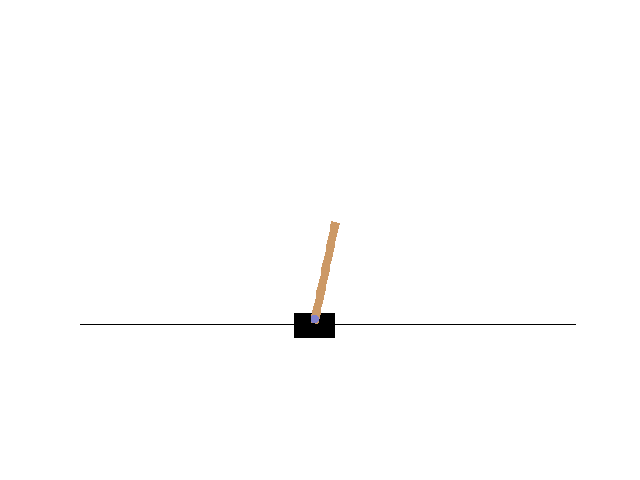

In [108]:
video = plot_animation(frames)
plt.show()

评估方式：信用分配

In [109]:
import tensorflow as tf

reset_graph()

n_inputs = 4
n_hidden = 4
n_outputs = 1

learning_rate = 0.01

initializer = tf.variance_scaling_initializer()

X = tf.placeholder(tf.float32, shape=[None, n_inputs])
y = tf.placeholder(tf.float32, shape=[None, n_outputs])

hidden = tf.layers.dense(X, n_hidden, activation=tf.nn.elu, kernel_initializer=initializer)
logits = tf.layers.dense(hidden, n_outputs)
outputs = tf.nn.sigmoid(logits) # probability of action 0 (left)
p_left_and_right = tf.concat(axis=1, values=[outputs, 1 - outputs])
action = tf.multinomial(tf.log(p_left_and_right), num_samples=1)
# 有了目标函数，就可以计算交叉熵损失
cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=logits)
optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(cross_entropy)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [110]:
n_environments = 10
n_iterations = 1000

envs = [gym.make("CartPole-v0") for _ in range(n_environments)]
observations = [env.reset() for env in envs]

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        # 目标是选择最好的行为:所以如果选择了行为0(左),目标概率就是1.0，选择了行为1，目标概率就是0
        target_probas = np.array([([1.] if obs[2] < 0 else [0.]) for obs in observations]) # if angle<0 we want proba(left)=1., or else proba(left)=0.
        action_val, _ = sess.run([action, training_op], feed_dict={X: np.array(observations), y: target_probas})
        # 定义了10个环境
        for env_index, env in enumerate(envs):
            obs, reward, done, info = env.step(action_val[env_index][0])
            observations[env_index] = obs if not done else env.reset()
    saver.save(sess, "./my_policy_net_basic.ckpt")

for env in envs:
    env.close()

In [111]:
def render_policy_net(model_path, action, X, n_max_steps = 1000):
    frames = []
    env = gym.make("CartPole-v0")
    obs = env.reset()
    with tf.Session() as sess:
        saver.restore(sess, model_path)
        for step in range(n_max_steps):
            img = render_cart_pole(env, obs)
            frames.append(img)
            action_val = action.eval(feed_dict={X: obs.reshape(1, n_inputs)})
            obs, reward, done, info = env.step(action_val[0][0])
            if done:
                break
    env.close()
    return frames        

INFO:tensorflow:Restoring parameters from ./my_policy_net_basic.ckpt


<IPython.core.display.Javascript object>


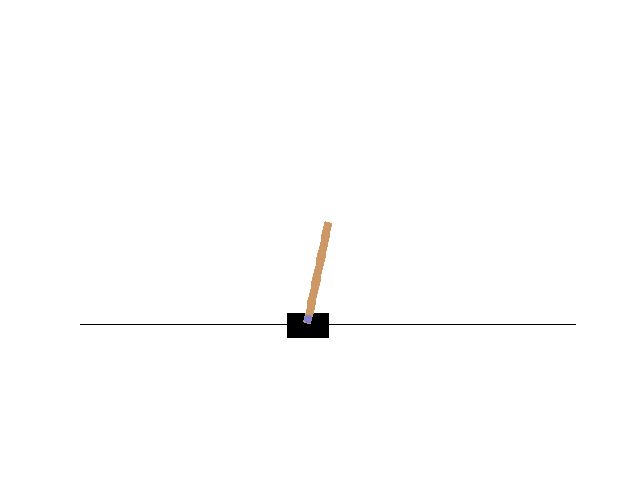

In [112]:
frames = render_policy_net("./my_policy_net_basic.ckpt", action, X)
video = plot_animation(frames)
plt.show()

然而，如果仅根据最后的结论，就决定好坏，这无疑是有不妥的。如果杆平衡了100次，那么我们怎么知道这100步中，哪一个行为比较好呢？我们只知道最后倒了。

这就是信用分配问题，当代理(智能体)获得回报时，很难知道哪些行为对该结果有正面或者负面的影响，可以想象，一只小狗表现好的几个小时后获得了奖励，它会明白为什么获得奖励了吗？

In [113]:
import tensorflow as tf

reset_graph()

n_inputs = 4
n_hidden = 4
n_outputs = 1

learning_rate = 0.01

initializer = tf.variance_scaling_initializer()

X = tf.placeholder(tf.float32, shape=[None, n_inputs])

hidden = tf.layers.dense(X, n_hidden, activation=tf.nn.elu, kernel_initializer=initializer)
logits = tf.layers.dense(hidden, n_outputs)
outputs = tf.nn.sigmoid(logits)  # probability of action 0 (left)
p_left_and_right = tf.concat(axis=1, values=[outputs, 1 - outputs])
action = tf.multinomial(tf.log(p_left_and_right), num_samples=1)

y = 1. - tf.to_float(action)
cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=logits)
optimizer = tf.train.AdamOptimizer(learning_rate)
# 只是计算，并不应用梯度下降
grads_and_vars = optimizer.compute_gradients(cross_entropy)

gradients = [grad for grad, variable in grads_and_vars]
# 应用梯度下降，传入函数更新过的梯度列表，而不是原始列表
gradient_placeholders = []
grads_and_vars_feed = []
for grad, variable in grads_and_vars:
    gradient_placeholder = tf.placeholder(tf.float32, shape=grad.get_shape())
    gradient_placeholders.append(gradient_placeholder)
    grads_and_vars_feed.append((gradient_placeholder, variable))
training_op = optimizer.apply_gradients(grads_and_vars_feed)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

计算总折扣回报，给出原始回报，并根据多次试验对结果归一化。

In [114]:
# 反向，等于衰减0.8，依次往后迭代损失
def discount_rewards(rewards, discount_rate):
    discounted_rewards = np.zeros(len(rewards))
    cumulative_rewards = 0
    for step in reversed(range(len(rewards))):
        cumulative_rewards = rewards[step] + cumulative_rewards * discount_rate
        discounted_rewards[step] = cumulative_rewards
    return discounted_rewards
# 将迭代后的损失归一化
def discount_and_normalize_rewards(all_rewards, discount_rate):
    all_discounted_rewards = [discount_rewards(rewards, discount_rate) for rewards in all_rewards]
    flat_rewards = np.concatenate(all_discounted_rewards)
    reward_mean = flat_rewards.mean()
    reward_std = flat_rewards.std()
    return [(discounted_rewards - reward_mean)/reward_std for discounted_rewards in all_discounted_rewards]

In [115]:
discount_rewards([10, 0, -50], discount_rate=0.8)

array([-22., -40., -50.])

In [116]:
discount_and_normalize_rewards([[10, 0, -50], [10, 20]], discount_rate=0.8)

[array([-0.28435071, -0.86597718, -1.18910299]),
 array([1.26665318, 1.0727777 ])]

In [47]:
env = gym.make("CartPole-v0")

n_games_per_update = 10
n_max_steps = 1000
n_iterations = 250
save_iterations = 10
discount_rate = 0.95

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        print("\rIteration: {}".format(iteration), end="")
        all_rewards = []
        all_gradients = []
        # 每10步下降一次，应用策略梯度
        for game in range(n_games_per_update):
            current_rewards = []
            current_gradients = []
            obs = env.reset()
            for step in range(n_max_steps):
                action_val, gradients_val = sess.run([action, gradients], feed_dict={X: obs.reshape(1, n_inputs)})
                obs, reward, done, info = env.step(action_val[0][0])
                current_rewards.append(reward)
                current_gradients.append(gradients_val)
                if done:
                    break
            all_rewards.append(current_rewards)
            all_gradients.append(current_gradients)
#         将所有的梯度做好计算，然后归一化
        all_rewards = discount_and_normalize_rewards(all_rewards, discount_rate=discount_rate)
        feed_dict = {}
#         取均值，然后梯度下降
        for var_index, gradient_placeholder in enumerate(gradient_placeholders):
            mean_gradients = np.mean([reward * all_gradients[game_index][step][var_index]
                                      for game_index, rewards in enumerate(all_rewards)
                                          for step, reward in enumerate(rewards)], axis=0)
            feed_dict[gradient_placeholder] = mean_gradients
        sess.run(training_op, feed_dict=feed_dict)
        if iteration % save_iterations == 0:
            saver.save(sess, "./my_policy_net_pg.ckpt")

Iteration: 249

In [48]:
env.close()

INFO:tensorflow:Restoring parameters from ./my_policy_net_pg.ckpt


<IPython.core.display.Javascript object>


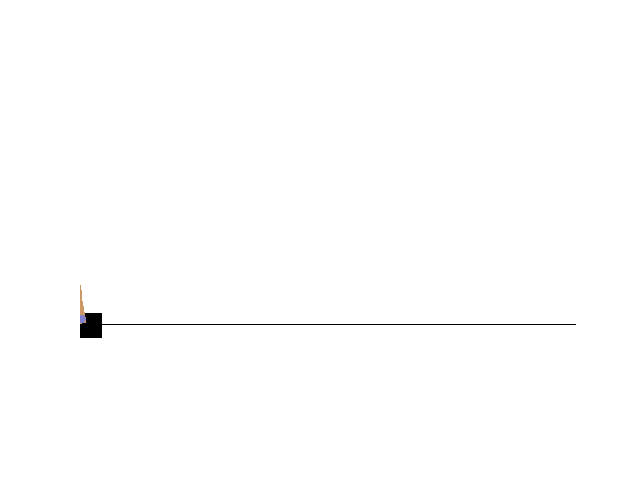

In [117]:
frames = render_policy_net("./my_policy_net_pg.ckpt", action, X, n_max_steps=1000)
video = plot_animation(frames)
plt.show()

In [46]:
transition_probabilities = [
        [0.7, 0.2, 0.0, 0.1],  # from s0 to s0, s1, s2, s3
        [0.0, 0.0, 0.9, 0.1],  # from s1 to ...
        [0.0, 1.0, 0.0, 0.0],  # from s2 to ...
        [0.0, 0.0, 0.0, 1.0],  # from s3 to ...
    ]

n_max_steps = 50

def print_sequence(start_state=0):
    current_state = start_state
    print("States:", end=" ")
    for step in range(n_max_steps):
        print(current_state, end=" ")
        if current_state == 3:
            break
        current_state = np.random.choice(range(4), p=transition_probabilities[current_state])
    else:
        print("...", end="")
    print()

for _ in range(10):
    print_sequence()

States: 0 0 3 
States: 0 1 2 1 2 1 2 1 2 1 3 
States: 0 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 3 
States: 0 3 
States: 0 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 3 
States: 0 1 3 
States: 0 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 ...
States: 0 0 3 
States: 0 0 0 1 2 1 2 1 3 
States: 0 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 3 


In [118]:
# 定义MDP
transition_probabilities = [
        [[0.7, 0.3, 0.0], [1.0, 0.0, 0.0], [0.8, 0.2, 0.0]], # in s0, if action a0 then proba 0.7 to state s0 and 0.3 to state s1, etc.
        [[0.0, 1.0, 0.0], None, [0.0, 0.0, 1.0]],
        [None, [0.8, 0.1, 0.1], None],
    ]

rewards = [
        [[+10, 0, 0], [0, 0, 0], [0, 0, 0]],
        [[0, 0, 0], [0, 0, 0], [0, 0, -50]],
        [[0, 0, 0], [+40, 0, 0], [0, 0, 0]],
    ]

possible_actions = [[0, 1, 2], [0, 2], [1]]

# 根据当前的状态 选择动作
def policy_fire(state):
    return [0, 2, 1][state] # 0-0  1-2  2-1

def policy_random(state):
    return np.random.choice(possible_actions[state]) # (0-0 1 2) (1-0 2) (2-1) 然后随机

def policy_safe(state):
    return [0, 0, 1][state] # 0-0 1-0 2-1

class MDPEnvironment(object):
    def __init__(self, start_state=0):
        self.start_state=start_state
        self.reset()
    def reset(self):
        self.total_rewards = 0
        self.state = self.start_state
    def step(self, action):
        next_state = np.random.choice(range(3), p=transition_probabilities[self.state][action])
        reward = rewards[self.state][action][next_state]
        self.state = next_state
        self.total_rewards += reward
        return self.state, reward

def run_episode(policy, n_steps, start_state=0, display=True):
    env = MDPEnvironment()
    if display:
        print("States (+rewards):", end=" ")
    for step in range(n_steps):
        if display:
            if step == 10:
                print("...", end=" ")
            elif step < 10:
                print(env.state, end=" ")
        action = policy(env.state)
        state, reward = env.step(action)
        if display and step < 10:
            if reward:
                print("({})".format(reward), end=" ")
    if display:
        print("Total rewards =", env.total_rewards)
    return env.total_rewards
# 根据三种策略，算三次，每次跑1000轮，每轮玩100次
for policy in (policy_fire, policy_random, policy_safe):
    all_totals = []
    print(policy.__name__)
    for episode in range(1000):
        all_totals.append(run_episode(policy, n_steps=100, display=(episode<5)))
    print("Summary: mean={:.1f}, std={:1f}, min={}, max={}".format(np.mean(all_totals), np.std(all_totals), np.min(all_totals), np.max(all_totals)))
    print()

policy_fire
States (+rewards): 0 (10) 0 1 (-50) 2 (40) 0 (10) 0 (10) 0 (10) 0 1 (-50) 2 (40) ... Total rewards = 160
States (+rewards): 0 (10) 0 (10) 0 (10) 0 (10) 0 1 (-50) 2 (40) 0 1 (-50) 2 (40) ... Total rewards = 130
States (+rewards): 0 (10) 0 (10) 0 (10) 0 1 (-50) 2 (40) 0 (10) 0 (10) 0 (10) 0 (10) ... Total rewards = 10
States (+rewards): 0 (10) 0 (10) 0 (10) 0 (10) 0 1 (-50) 2 (40) 0 (10) 0 1 (-50) ... Total rewards = 180
States (+rewards): 0 (10) 0 1 (-50) 2 1 (-50) 2 1 (-50) 2 (40) 0 1 (-50) ... Total rewards = -70
Summary: mean=121.2, std=129.755477, min=-330, max=470

policy_random
States (+rewards): 0 0 0 0 0 0 0 0 0 0 ... Total rewards = 0
States (+rewards): 0 (10) 0 0 1 (-50) 2 1 (-50) 2 (40) 0 0 (10) 0 (10) ... Total rewards = 30
States (+rewards): 0 0 0 (10) 0 0 1 1 1 1 1 (-50) ... Total rewards = -50
States (+rewards): 0 0 0 (10) 0 0 0 (10) 0 0 0 0 ... Total rewards = 10
States (+rewards): 0 0 0 1 (-50) 2 (40) 0 0 0 (10) 0 1 (-50) ... Total rewards = 30
Summary: mean

In [119]:
# Q值迭代算法
n_states = 3
n_actions = 3
n_steps = 20000
alpha = 0.01

gamma = 0.99
exploration_policy = policy_random
# 初始化为负无穷
q_values = np.full((n_states, n_actions), -np.inf)
# 可能的地方初始化为0
for state, actions in enumerate(possible_actions):
    q_values[state][actions]=0

env = MDPEnvironment()
for step in range(n_steps):
    action = exploration_policy(env.state)
    state = env.state
    next_state, reward = env.step(action)
    next_value = np.max(q_values[next_state]) # greedy policy
    # TD学习算法 + Q学习算法
    q_values[state, action] = (1-alpha)*q_values[state, action] + alpha*(reward + gamma * next_value)

In [120]:
# 返回根据当前状态的最优动作
def optimal_policy(state):
    return np.argmax(q_values[state])

In [121]:
# 三种状态下的动作选择
q_values # 状态s0 ->a0  状态s2->a2

array([[39.59093659, 38.93869394, 35.55927839],
       [18.70530829,        -inf, 20.30294145],
       [       -inf, 73.44174534,        -inf]])

In [122]:
all_totals = []
for episode in range(1000):
    all_totals.append(run_episode(optimal_policy, n_steps=100, display=(episode<5)))
print("Summary: mean={:.1f}, std={:1f}, min={}, max={}".format(np.mean(all_totals), np.std(all_totals), np.min(all_totals), np.max(all_totals)))
print()

States (+rewards): 0 (10) 0 (10) 0 1 (-50) 2 (40) 0 (10) 0 1 (-50) 2 (40) 0 ... Total rewards = 70
States (+rewards): 0 1 (-50) 2 (40) 0 (10) 0 (10) 0 (10) 0 (10) 0 (10) 0 (10) 0 (10) ... Total rewards = 170
States (+rewards): 0 1 (-50) 2 (40) 0 1 (-50) 2 (40) 0 (10) 0 (10) 0 1 (-50) ... Total rewards = 210
States (+rewards): 0 (10) 0 (10) 0 (10) 0 (10) 0 (10) 0 (10) 0 (10) 0 (10) 0 1 (-50) ... Total rewards = 150
States (+rewards): 0 (10) 0 (10) 0 (10) 0 (10) 0 1 (-50) 2 (40) 0 (10) 0 (10) 0 (10) ... Total rewards = 430
Summary: mean=122.4, std=133.440578, min=-350, max=610



In [123]:
env = gym.make("MsPacman-v0")
obs = env.reset()
obs.shape

(210, 160, 3)

In [124]:
env.action_space

Discrete(9)

In [125]:
mspacman_color = 210 + 164 + 74

def preprocess_observation(obs):
    img = obs[1:176:2, ::2] # crop and downsize
    img = img.sum(axis=2) # to greyscale
    img[img==mspacman_color] = 0 # Improve contrast
    img = (img // 3 - 128).astype(np.int8) # normalize from -128 to 127
    return img.reshape(88, 80, 1)

img = preprocess_observation(obs)

<IPython.core.display.Javascript object>


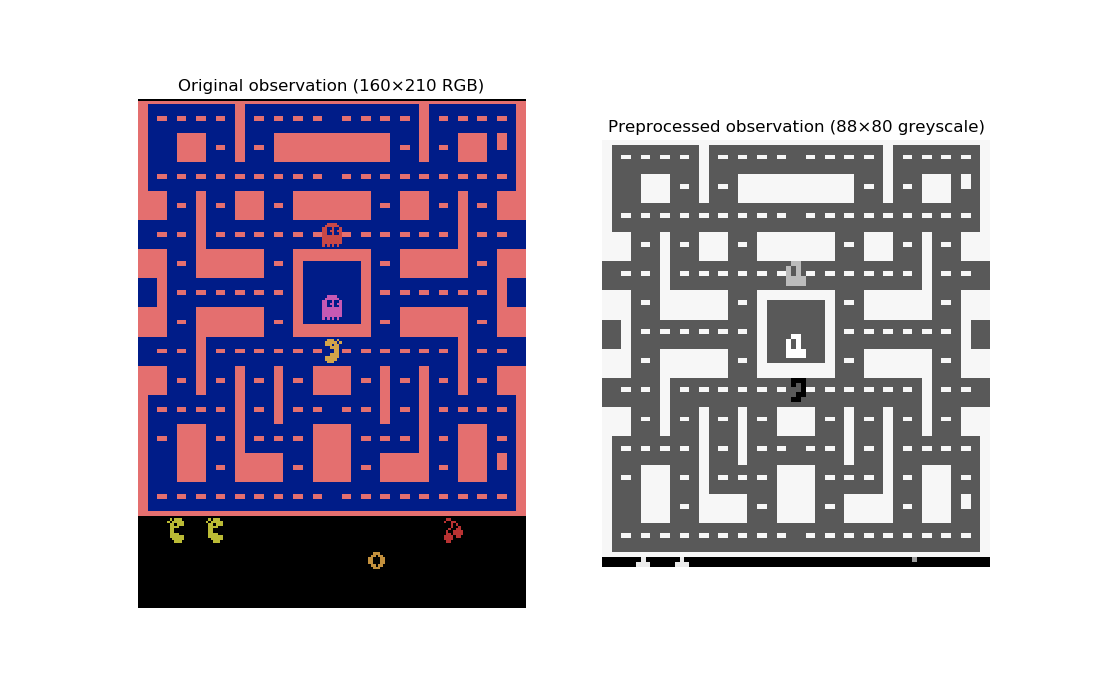

In [126]:
plt.figure(figsize=(11, 7))
plt.subplot(121)
plt.title("Original observation (160×210 RGB)")
plt.imshow(obs)
plt.axis("off")
plt.subplot(122)
plt.title("Preprocessed observation (88×80 greyscale)")
plt.imshow(img.reshape(88, 80), interpolation="nearest", cmap="gray")
plt.axis("off")
# save_fig("preprocessing_plot")
plt.show()

In [127]:
reset_graph()

input_height = 88
input_width = 80
input_channels = 1
conv_n_maps = [32, 64, 64]
conv_kernel_sizes = [(8,8), (4,4), (3,3)]
conv_strides = [4, 2, 1]
conv_paddings = ["SAME"] * 3 
conv_activation = [tf.nn.relu] * 3
n_hidden_in = 64 * 11 * 10  # conv3 has 64 maps of 11x10 each
n_hidden = 512
hidden_activation = tf.nn.relu
n_outputs = env.action_space.n  # 9 discrete actions are available
initializer = tf.variance_scaling_initializer()

def q_network(X_state, name):
    prev_layer = X_state / 128.0 # scale pixel intensities to the [-1.0, 1.0] range.
    with tf.variable_scope(name) as scope:
        for n_maps, kernel_size, strides, padding, activation in zip(
                conv_n_maps, conv_kernel_sizes, conv_strides,
                conv_paddings, conv_activation):
            prev_layer = tf.layers.conv2d(
                prev_layer, filters=n_maps, kernel_size=kernel_size,
                strides=strides, padding=padding, activation=activation,
                kernel_initializer=initializer)
        last_conv_layer_flat = tf.reshape(prev_layer, shape=[-1, n_hidden_in])
        hidden = tf.layers.dense(last_conv_layer_flat, n_hidden,
                                 activation=hidden_activation,
                                 kernel_initializer=initializer)
        outputs = tf.layers.dense(hidden, n_outputs,
                                  kernel_initializer=initializer)
    trainable_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,
                                       scope=scope.name)
    trainable_vars_by_name = {var.name[len(scope.name):]: var
                              for var in trainable_vars}
    # 返回所有的可训练变量
    return outputs, trainable_vars_by_name

让演员玩一会，然后评论家评论演员玩的如何

In [129]:
X_state = tf.placeholder(tf.float32, shape=[None, input_height, input_width,
                                            input_channels])
# 评论家
online_q_values, online_vars = q_network(X_state, name="q_networks/online")
# 演员
target_q_values, target_vars = q_network(X_state, name="q_networks/target")
# 将评论家参数赋值到演员
copy_ops = [target_var.assign(online_vars[var_name])
            for var_name, target_var in target_vars.items()]
copy_online_to_target = tf.group(*copy_ops)

In [130]:
online_vars

{'/conv2d/kernel:0': <tf.Variable 'q_networks/online/conv2d/kernel:0' shape=(8, 8, 1, 32) dtype=float32_ref>,
 '/conv2d/bias:0': <tf.Variable 'q_networks/online/conv2d/bias:0' shape=(32,) dtype=float32_ref>,
 '/conv2d_1/kernel:0': <tf.Variable 'q_networks/online/conv2d_1/kernel:0' shape=(4, 4, 32, 64) dtype=float32_ref>,
 '/conv2d_1/bias:0': <tf.Variable 'q_networks/online/conv2d_1/bias:0' shape=(64,) dtype=float32_ref>,
 '/conv2d_2/kernel:0': <tf.Variable 'q_networks/online/conv2d_2/kernel:0' shape=(3, 3, 64, 64) dtype=float32_ref>,
 '/conv2d_2/bias:0': <tf.Variable 'q_networks/online/conv2d_2/bias:0' shape=(64,) dtype=float32_ref>,
 '/dense/kernel:0': <tf.Variable 'q_networks/online/dense/kernel:0' shape=(7040, 512) dtype=float32_ref>,
 '/dense/bias:0': <tf.Variable 'q_networks/online/dense/bias:0' shape=(512,) dtype=float32_ref>,
 '/dense_1/kernel:0': <tf.Variable 'q_networks/online/dense_1/kernel:0' shape=(512, 9) dtype=float32_ref>,
 '/dense_1/bias:0': <tf.Variable 'q_networks/onl

In [131]:
learning_rate = 0.001
momentum = 0.95
# Deep-Q-learning
with tf.variable_scope("train"):
    X_action = tf.placeholder(tf.int32, shape=[None])
    y = tf.placeholder(tf.float32, shape=[None, 1])
    q_value = tf.reduce_sum(online_q_values * tf.one_hot(X_action, n_outputs),
                            axis=1, keepdims=True)
    # 演员的与评论家的均方差
    error = tf.abs(y - q_value)
    clipped_error = tf.clip_by_value(error, 0.0, 1.0)
    linear_error = 2 * (error - clipped_error)
    loss = tf.reduce_mean(tf.square(clipped_error) + linear_error)

    global_step = tf.Variable(0, trainable=False, name='global_step')
    optimizer = tf.train.MomentumOptimizer(learning_rate, momentum, use_nesterov=True)
    training_op = optimizer.minimize(loss, global_step=global_step)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [132]:
# 重播存储器
# 双向队列
class ReplayMemory:
    def __init__(self, maxlen):
        self.maxlen = maxlen
        self.buf = np.empty(shape=maxlen, dtype=np.object)
        self.index = 0
        self.length = 0
        
    def append(self, data):
        self.buf[self.index] = data
        self.length = min(self.length + 1, self.maxlen)
        self.index = (self.index + 1) % self.maxlen
    
    def sample(self, batch_size, with_replacement=True):
        if with_replacement:
            indices = np.random.randint(self.length, size=batch_size) # faster
        else:
            indices = np.random.permutation(self.length)[:batch_size]
        return self.buf[indices]

In [133]:
replay_memory_size = 500000
replay_memory = ReplayMemory(replay_memory_size)

In [134]:
def sample_memories(batch_size):
    cols = [[], [], [], [], []] # state, action, reward, next_state, continue
    for memory in replay_memory.sample(batch_size):
        for col, value in zip(cols, memory):
            col.append(value)
    cols = [np.array(col) for col in cols]
    return cols[0], cols[1], cols[2].reshape(-1, 1), cols[3], cols[4].reshape(-1, 1)

In [135]:
# epsilon_greedy 策略
eps_min = 0.1
eps_max = 1.0
eps_decay_steps = 2000000

def epsilon_greedy(q_values, step):
    epsilon = max(eps_min, eps_max - (eps_max-eps_min) * step/eps_decay_steps)
    if np.random.rand() < epsilon:
        return np.random.randint(n_outputs) # random action
    else:
        return np.argmax(q_values) # optimal action

In [136]:
n_steps = 4000000  # total number of training steps
training_start = 10000  # start training after 10,000 game iterations
training_interval = 4  # run a training step every 4 game iterations
save_steps = 1000  # save the model every 1,000 training steps
copy_steps = 10000  # copy online DQN to target DQN every 10,000 training steps
discount_rate = 0.99
skip_start = 90  # Skip the start of every game (it's just waiting time).
batch_size = 50
iteration = 0  # game iterations
checkpoint_path = "./my_dqn.ckpt"
done = True # env needs to be reset

In [137]:
loss_val = np.infty
game_length = 0
total_max_q = 0
mean_max_q = 0.0

In [77]:
with tf.Session() as sess:
    # 是否恢复训练参数
    if os.path.isfile(checkpoint_path + ".index"):
        saver.restore(sess, checkpoint_path)
    else:
        init.run()
        copy_online_to_target.run()
    # 循环训练
    while True:
        # 训练 n_steps步
        step = global_step.eval()
        if step >= n_steps:
            break
        iteration += 1
        print("\rIteration {}\tTraining step {}/{} ({:.1f})%\tLoss {:5f}\tMean Max-Q {:5f}   ".format(
            iteration, step, n_steps, step * 100 / n_steps, loss_val, mean_max_q), end="")
        if done: # game over, start again
            obs = env.reset()
            for skip in range(skip_start): # skip the start of each game
                obs, reward, done, info = env.step(0)
            # 预处理画面
            state = preprocess_observation(obs)

        # Online DQN evaluates what to do
        q_values = online_q_values.eval(feed_dict={X_state: [state]})
        action = epsilon_greedy(q_values, step)

        # Online DQN plays
        obs, reward, done, info = env.step(action)
        next_state = preprocess_observation(obs)

        # Let's memorize what happened
        replay_memory.append((state, action, reward, next_state, 1.0 - done))
        state = next_state

        # Compute statistics for tracking progress (not shown in the book)
        total_max_q += q_values.max()
        game_length += 1
        if done:
            mean_max_q = total_max_q / game_length
            total_max_q = 0.0
            game_length = 0
            
        # 热启动以后，才需要评论
        if iteration < training_start or iteration % training_interval != 0:
            continue # only train after warmup period and at regular intervals
        
        # Sample memories and use the target DQN to produce the target Q-Value
        # 评论家来评论
        X_state_val, X_action_val, rewards, X_next_state_val, continues = (
            sample_memories(batch_size))
        next_q_values = target_q_values.eval(
            feed_dict={X_state: X_next_state_val})
        max_next_q_values = np.max(next_q_values, axis=1, keepdims=True)
        y_val = rewards + continues * discount_rate * max_next_q_values

        # Train the online DQN
        _, loss_val = sess.run([training_op, loss], feed_dict={
            X_state: X_state_val, X_action: X_action_val, y: y_val})

        # Regularly copy the online DQN to the target DQN
        if step % copy_steps == 0:
            copy_online_to_target.run()

        # And save regularly
        if step % save_steps == 0:
            saver.save(sess, checkpoint_path)

Iteration 16009996	Training step 3999999/4000000 (100.0)%	Loss 4.739191	Mean Max-Q 168.942862    

In [138]:
frames = []
n_max_steps = 10000

with tf.Session() as sess:
    saver.restore(sess, checkpoint_path)

    obs = env.reset()
    for step in range(n_max_steps):
        state = preprocess_observation(obs)

        # Online DQN evaluates what to do
        q_values = online_q_values.eval(feed_dict={X_state: [state]})
        action = np.argmax(q_values)

        # Online DQN plays
        obs, reward, done, info = env.step(action)

        img = env.render(mode="rgb_array")
        frames.append(img)

        if done:
            break

INFO:tensorflow:Restoring parameters from ./my_dqn.ckpt


<IPython.core.display.Javascript object>


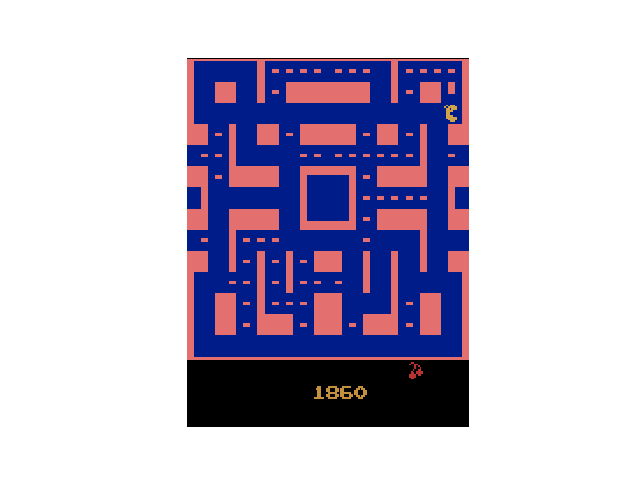

In [139]:
plot_animation(frames)

In [82]:
def preprocess_observation(obs):
    img = obs[34:194:2, ::2] # crop and downsize
    return np.mean(img, axis=2).reshape(80, 80) / 255.0

In [83]:
env = gym.make("Breakout-v0")
obs = env.reset()
for step in range(10):
    obs, _, _, _ = env.step(1)

img = preprocess_observation(obs)

<IPython.core.display.Javascript object>


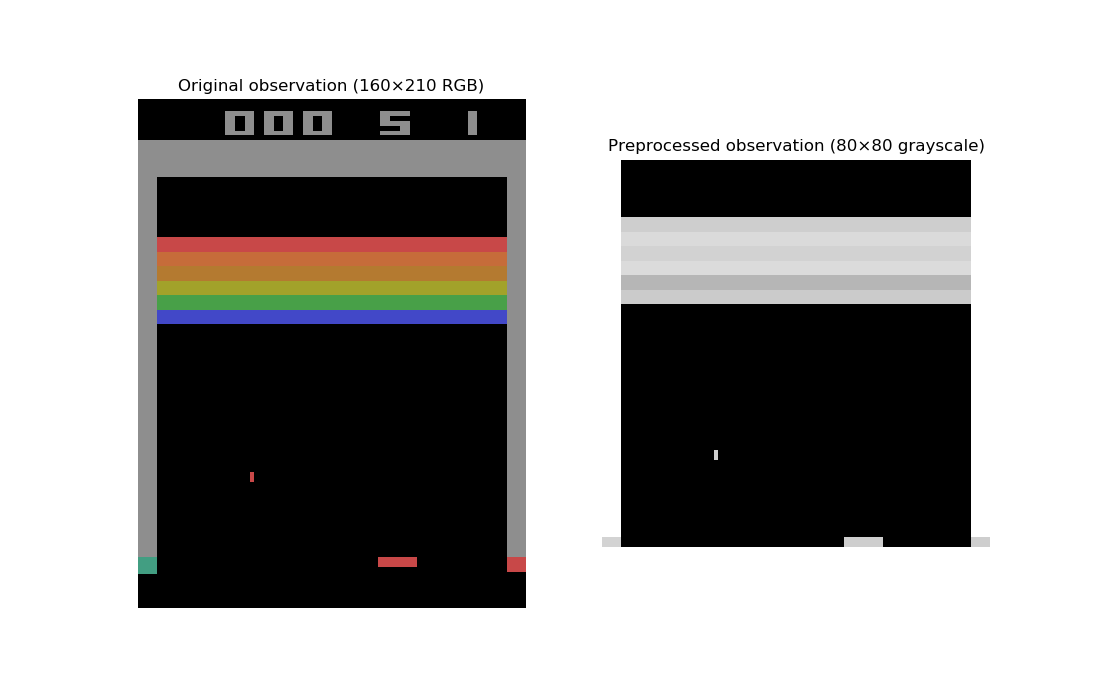

In [84]:
plt.figure(figsize=(11, 7))
plt.subplot(121)
plt.title("Original observation (160×210 RGB)")
plt.imshow(obs)
plt.axis("off")
plt.subplot(122)
plt.title("Preprocessed observation (80×80 grayscale)")
plt.imshow(img, interpolation="nearest", cmap="gray")
plt.axis("off")
plt.show()

In [85]:
from collections import deque

def combine_observations_multichannel(preprocessed_observations):
    return np.array(preprocessed_observations).transpose([1, 2, 0])

def combine_observations_singlechannel(preprocessed_observations, dim_factor=0.5):
    dimmed_observations = [obs * dim_factor**index
                           for index, obs in enumerate(reversed(preprocessed_observations))]
    return np.max(np.array(dimmed_observations), axis=0)

n_observations_per_state = 3
preprocessed_observations = deque([], maxlen=n_observations_per_state)

obs = env.reset()
for step in range(10):
    obs, _, _, _ = env.step(1)
    preprocessed_observations.append(preprocess_observation(obs))

<IPython.core.display.Javascript object>


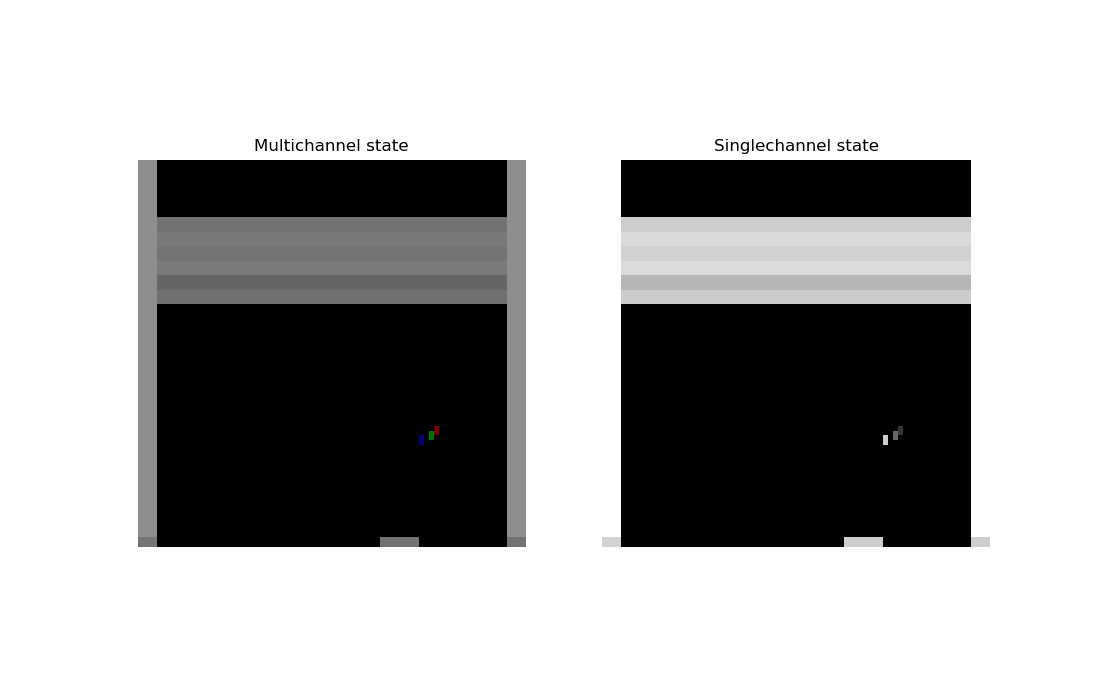

In [86]:
img1 = combine_observations_multichannel(preprocessed_observations)
img2 = combine_observations_singlechannel(preprocessed_observations)

plt.figure(figsize=(11, 7))
plt.subplot(121)
plt.title("Multichannel state")
plt.imshow(img1, interpolation="nearest")
plt.axis("off")
plt.subplot(122)
plt.title("Singlechannel state")
plt.imshow(img2, interpolation="nearest", cmap="gray")
plt.axis("off")
plt.show()

In [6]:
import gym

In [7]:
env = gym.make("BipedalWalker-v2")

In [9]:
obs = env.reset()

In [10]:
img = env.render(mode="rgb_array")

<IPython.core.display.Javascript object>


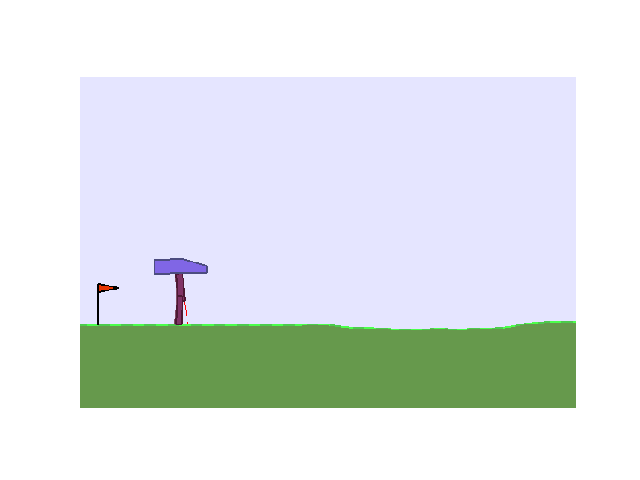

In [11]:
plt.imshow(img)
plt.axis("off")
plt.show()

In [12]:
obs

array([ 2.74753268e-03, -3.65813670e-06,  2.84560388e-04, -1.59999776e-02,
        9.21002626e-02, -3.75518517e-04,  8.60189095e-01,  1.68077198e-03,
        1.00000000e+00,  3.25057320e-02, -3.75494099e-04,  8.53737861e-01,
        2.65571657e-04,  1.00000000e+00,  4.40814018e-01,  4.45820123e-01,
        4.61422771e-01,  4.89550203e-01,  5.34102798e-01,  6.02461040e-01,
        7.09148884e-01,  8.85931849e-01,  1.00000000e+00,  1.00000000e+00])

In [13]:
env.action_space

Box(4,)

In [14]:
env.action_space.low

array([-1., -1., -1., -1.], dtype=float32)

In [15]:
env.action_space.high

array([1., 1., 1., 1.], dtype=float32)

In [11]:
from itertools import product

In [12]:
possible_torques = np.array([-1.0, 0.0, 1.0])
possible_actions = np.array(list(product(possible_torques, possible_torques, possible_torques, possible_torques)))
possible_actions.shape

(81, 4)

In [13]:
import tensorflow as tf

In [14]:
tf.reset_default_graph()

# 1. Specify the network architecture
n_inputs = env.observation_space.shape[0]  # == 24
n_hidden = 10
n_outputs = len(possible_actions) # == 625
initializer = tf.variance_scaling_initializer()

# 2. Build the neural network
X = tf.placeholder(tf.float32, shape=[None, n_inputs])

hidden = tf.layers.dense(X, n_hidden, activation=tf.nn.selu,
                         kernel_initializer=initializer)
logits = tf.layers.dense(hidden, n_outputs,
                         kernel_initializer=initializer)
outputs = tf.nn.softmax(logits)

# 3. Select a random action based on the estimated probabilities
action_index = tf.squeeze(tf.multinomial(logits, num_samples=1), axis=-1)

# 4. Training
learning_rate = 0.01

y = tf.one_hot(action_index, depth=len(possible_actions))
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(labels=y, logits=logits)
optimizer = tf.train.AdamOptimizer(learning_rate)
grads_and_vars = optimizer.compute_gradients(cross_entropy)
gradients = [grad for grad, variable in grads_and_vars]
gradient_placeholders = []
grads_and_vars_feed = []
for grad, variable in grads_and_vars:
    gradient_placeholder = tf.placeholder(tf.float32, shape=grad.get_shape())
    gradient_placeholders.append(gradient_placeholder)
    grads_and_vars_feed.append((gradient_placeholder, variable))
training_op = optimizer.apply_gradients(grads_and_vars_feed)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.random.categorical instead.


In [24]:
def run_bipedal_walker(model_path=None, n_max_steps = 1000):
    env = gym.make("BipedalWalker-v2")
    frames = []
    with tf.Session() as sess:
        if model_path is None:
            init.run()
        else:
            saver.restore(sess, model_path)
        obs = env.reset()
        for step in range(n_max_steps):
            img = env.render(mode="rgb_array")
            frames.append(img)
            action_index_val = action_index.eval(feed_dict={X: obs.reshape(1, n_inputs)})
            action = possible_actions[action_index_val]
            obs, reward, done, info = env.step(action[0])
            if done:
                break
            print ("\r Loading... "+str(step), end="")
            sys.stdout.flush()
    env.close()
    return frames

In [25]:
frames = run_bipedal_walker()

 Loading... 47

In [ ]:
video = plot_animation(frames)
plt.show()

In [15]:
n_games_per_update = 10
n_max_steps = 1000
n_iterations = 1000
save_iterations = 10
discount_rate = 0.95

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        print("\rIteration: {}/{}".format(iteration + 1, n_iterations), end="")
        all_rewards = []
        all_gradients = []
        for game in range(n_games_per_update):
            current_rewards = []
            current_gradients = []
            obs = env.reset()
            for step in range(n_max_steps):
                action_index_val, gradients_val = sess.run([action_index, gradients],
                                                           feed_dict={X: obs.reshape(1, n_inputs)})
                action = possible_actions[action_index_val]
                obs, reward, done, info = env.step(action[0])
                current_rewards.append(reward)
                current_gradients.append(gradients_val)
                if done:
                    break
            all_rewards.append(current_rewards)
            all_gradients.append(current_gradients)

        all_rewards = discount_and_normalize_rewards(all_rewards, discount_rate=discount_rate)
        feed_dict = {}
        for var_index, gradient_placeholder in enumerate(gradient_placeholders):
            mean_gradients = np.mean([reward * all_gradients[game_index][step][var_index]
                                      for game_index, rewards in enumerate(all_rewards)
                                          for step, reward in enumerate(rewards)], axis=0)
            feed_dict[gradient_placeholder] = mean_gradients
        sess.run(training_op, feed_dict=feed_dict)
        if iteration % save_iterations == 0:
            saver.save(sess, "./my_bipedal_walker_pg.ckpt")

Iteration: 1000/1000

In [16]:
def run_bipedal_walker(model_path=None, n_max_steps = 1000):
    env = gym.make("BipedalWalker-v2")
    frames = []
    with tf.Session() as sess:
        if model_path is None:
            init.run()
        else:
            saver.restore(sess, model_path)
        obs = env.reset()
        for step in range(n_max_steps):
            env.render()
#             frames.append(img)
            action_index_val = action_index.eval(feed_dict={X: obs.reshape(1, n_inputs)})
            action = possible_actions[action_index_val]
            obs, reward, done, info = env.step(action[0])
            if done:
                break
            print ("\r Loading... "+str(step), end="")
            sys.stdout.flush()
    env.close()
#     return frames

In [19]:
# frames = run_bipedal_walker("./my_bipedal_walker_pg.ckpt")
# video = plot_animation(frames)
# plt.show()
run_bipedal_walker("./my_bipedal_walker_pg.ckpt")

INFO:tensorflow:Restoring parameters from ./my_bipedal_walker_pg.ckpt
 Loading... 106